# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_score, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import tensorflow.keras.regularizers as regularizers



In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Processing

In [3]:
train_df = pd.read_csv("train_data_v3.csv")
validate_df = pd.read_csv("validate_data_v3.csv")
test_df = pd.read_csv("test_data_v3.csv")

In [4]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 42)
(1000, 42)
(1000, 42)


In [5]:
train_df.head()

,ID,End_Time,Distance(mi),Description,Zipcode,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,City_Los Angeles,City_Miami,City_Orlando,City_Others,Weather_Condition_Encoded,Weather_Condition_Fog / Low Visibility,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,2022-08-03 05:53:00,77.0,88.0,29.81,10.0,...,0,0,0,1,0,0,0,0,0,1
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,2020-06-03 14:45:00,75.0,65.0,28.84,20.0,...,0,0,0,1,0,0,0,0,0,1
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,2022-08-11 09:54:00,79.0,84.0,29.80,10.0,...,0,0,0,1,0,0,0,0,0,1
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,2022-07-25 07:53:00,82.0,79.0,29.98,10.0,...,0,0,0,0,0,0,0,0,0,1
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,2020-05-20 15:55:00,86.0,55.0,29.91,10.0,...,0,0,0,1,0,0,0,0,0,1


In [6]:
train_df.dtypes

,0
ID,object
End_Time,int64
Distance(mi),float64
Description,object
Zipcode,object
Weather_Timestamp,object
Temperature(F),float64
Humidity(%),float64
Pressure(in),float64
Visibility(mi),float64


In [7]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"Missing values in {name}:")
    print(df.isna().sum())
    print("\n")


Missing values in train_df:
ID                                                  0
End_Time                                            0
Distance(mi)                                        0
Description                                         0
Zipcode                                             0
Weather_Timestamp                                   0
Temperature(F)                                      0
Humidity(%)                                         0
Pressure(in)                                        0
Visibility(mi)                                      0
Wind_Direction                                      0
Wind_Speed(mph)                                     0
Precipitation(in)                                   0
Amenity                                             0
Bump                                                0
Crossing                                            0
Give_Way                                            0
Junction                                            0


### Process datetime column

In [8]:
def encode_timestamp(df):
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], errors='coerce')

    # Extract features
    df['Weather_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Hour'] = df['Weather_Timestamp'].dt.hour
    df['Weather_Day_of_Week'] = df['Weather_Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    df['Weather_Is_Weekend'] = df['Weather_Day_of_Week'].isin([5, 6]).astype(int)

    df.drop(columns=['Weather_Timestamp'], inplace=True)
    return df

In [9]:
print(train_df.columns)
train_df = encode_timestamp(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

Index(['ID', 'End_Time', 'Distance(mi)', 'Description', 'Zipcode',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Duration', 'Region', 'State_CA', 'State_FL',
       'State_Others', 'State_TX', 'City_Charlotte', 'City_Houston',
       'City_Los Angeles', 'City_Miami', 'City_Orlando', 'City_Others',
       'Weather_Condition_Encoded', 'Weather_Condition_Fog / Low Visibility',
       'Weather_Condition_Others', 'Weather_Condition_Snow',
       'Weather_Condition_Thunderstorms / Severe Weather', 'Severity'],
      dtype='object')
train_df shape: (8000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,10.0,CALM,...,0,0,0,1,2022,8,3,5,2,0
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,20.0,W,...,0,0,0,1,2020,6,3,14,2,0
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,10.0,VAR,...,0,0,0,1,2022,8,11,9,3,0
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,10.0,CALM,...,0,0,0,1,2022,7,25,7,0,0
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,10.0,SW,...,0,0,0,1,2020,5,20,15,2,0


In [10]:
validate_df = encode_timestamp(validate_df)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6440727,1376,0.013,Incident on E HOLT BLVD near CORONA AVE Drive ...,91761-2110,46.0,83.0,29.02,10.0,CALM,...,0,0,0,2,2021,1,29,20,4,0
1,A-3749509,1152,0.086,Incident on BISCAYNE BAY DR near HOUSE 12700 D...,33181,79.0,62.0,30.05,10.0,NE,...,0,0,0,2,2022,12,5,16,0,0
2,A-7118981,928,0.700,At MD-5/Branch Ave/Exit 7 - Accident.,20748,60.0,55.0,29.80,10.0,W,...,0,0,0,3,2020,3,17,14,1,0
3,A-2308799,327,0.000,Accident on I-94 Westbound at Exit 208 Schaefe...,48120,18.0,84.0,31.08,1.2,East,...,0,1,0,3,2019,2,27,4,2,0
4,A-5403565,656,0.386,Crash blocking the left lane on SR-260 Westbou...,85541,72.0,69.0,25.02,10.0,CALM,...,0,0,0,2,2022,7,30,9,5,1


In [11]:
test_df = encode_timestamp(test_df)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-924015,484,0.000,Lane blocked due to accident on OR-238 Westbou...,97530,54.0,66.0,28.71,8.0,CALM,...,0,0,0,2,2021,8,26,6,3,0
1,A-1744687,556,0.000,Accident on CR-266 John St both ways at Perkin...,14623-2417,40.0,93.0,29.73,7.0,CALM,...,0,0,0,2,2019,10,10,7,3,0
2,A-5488029,1109,0.711,Slow traffic on I-20 W from SC-215/Monticello ...,29210,82.0,69.0,29.62,10.0,SW,...,0,0,0,2,2021,6,22,17,1,0
3,A-3844411,974,0.141,NYSDOT - Region 8: Crash on Taconic State Park...,12037,32.0,96.0,28.60,3.0,CALM,...,0,1,0,2,2023,1,19,14,3,0
4,A-1353192,616,0.000,Accident on Illinois Ave at 48th Ave.,37209-3441,68.0,81.0,29.56,10.0,E,...,0,0,0,2,2020,10,22,8,3,0


### Process categorical columns

In [12]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"--- {name} ---")
    for col in ['Wind_Direction', 'Description', 'Zipcode']:
        unique_values = df[col].unique()
        value_counts = df[col].value_counts()

        print(f"\nColumn: {col}")
        print(f"Unique values ({len(unique_values)}): {unique_values}")
        print("Value counts:")
        print(value_counts)
        print("-" * 40)
    print("\n" + "=" * 60 + "\n")



--- train_df ---

Column: Wind_Direction
Unique values (23): ['CALM' 'W' 'VAR' 'SW' 'SE' 'S' 'WSW' 'E' 'NE' 'N' 'NNW' 'SSW' 'NNE' 'NW'
 'ESE' 'ENE' 'SSE' 'WNW' 'North' 'West' 'South' 'Variable' 'East']
Value counts:
Wind_Direction
CALM        1301
S            641
W            553
SSW          457
N            427
SW           420
WNW          416
SSE          383
WSW          382
VAR          378
NW           372
E            363
NNW          334
SE           326
NNE          294
ESE          274
ENE          273
NE           245
East          43
South         39
North         37
West          26
Variable      16
Name: count, dtype: int64
----------------------------------------

Column: Description
Unique values (7823): ['Crash on Hard Scrabble Rd at Clemson Rd.'
 'At OH-87/S Woodland Rd - Accident.'
 'Crash on Rosewood Ave at Nansemond St.' ...
 'At Pleasant Hill Rd - Accident.'
 'Closed at US-220-BR/VA-457/Memorial Blvd - Road closed due to accident.'
 'Closed between CR-19/S Cente

In [13]:
def encode_categorical(df, reference_columns=None):
    # One-hot encode 'Wind_Direction'
    df = pd.get_dummies(df, columns=['Wind_Direction'], drop_first=True)

    # Convert True/False to 0/1 after encoding
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Ensure consistent columns for validate/test DataFrame
    if reference_columns is not None:
        missing_cols = [col for col in reference_columns if col not in df.columns]
        for col in missing_cols:
            df[col] = 0  # Add missing columns with 0s
        df = df[reference_columns]

    return df

In [14]:
train_df = encode_categorical(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,20.0,17.0,...,0,0,0,0,0,0,1,0,0,0
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,10.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,10.0,7.0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
validate_df = encode_categorical(validate_df, reference_columns=train_df.columns)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6440727,1376,0.013,Incident on E HOLT BLVD near CORONA AVE Drive ...,91761-2110,46.0,83.0,29.02,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-3749509,1152,0.086,Incident on BISCAYNE BAY DR near HOUSE 12700 D...,33181,79.0,62.0,30.05,10.0,9.0,...,0,0,0,0,0,0,0,0,0,0
2,A-7118981,928,0.700,At MD-5/Branch Ave/Exit 7 - Accident.,20748,60.0,55.0,29.80,10.0,13.0,...,0,0,0,0,0,0,1,0,0,0
3,A-2308799,327,0.000,Accident on I-94 Westbound at Exit 208 Schaefe...,48120,18.0,84.0,31.08,1.2,10.4,...,0,0,0,0,0,0,0,0,0,0
4,A-5403565,656,0.386,Crash blocking the left lane on SR-260 Westbou...,85541,72.0,69.0,25.02,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_df = encode_categorical(test_df, reference_columns=train_df.columns)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-924015,484,0.000,Lane blocked due to accident on OR-238 Westbou...,97530,54.0,66.0,28.71,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-1744687,556,0.000,Accident on CR-266 John St both ways at Perkin...,14623-2417,40.0,93.0,29.73,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,A-5488029,1109,0.711,Slow traffic on I-20 W from SC-215/Monticello ...,29210,82.0,69.0,29.62,10.0,9.0,...,0,0,1,0,0,0,0,0,0,0
3,A-3844411,974,0.141,NYSDOT - Region 8: Crash on Taconic State Park...,12037,32.0,96.0,28.60,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,A-1353192,616,0.000,Accident on Illinois Ave at 48th Ave.,37209-3441,68.0,81.0,29.56,10.0,3.0,...,0,0,0,0,0,0,0,0,0,0


### Drop irrelevant columns

In [17]:
irrelevant_columns = ["ID", "Description", "Zipcode"]
train_df = train_df.drop(columns=irrelevant_columns, errors='ignore')
validate_df = validate_df.drop(columns=irrelevant_columns, errors='ignore')
test_df = test_df.drop(columns=irrelevant_columns, errors='ignore')

# Evaluation Function

In [18]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    # y_pred_prob = model.predict_proba(X_test)
    y_pred_prob = model.predict(X_test) # compatible issue
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Define Features & Target

In [19]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]

# Scale the data before feature selection and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Baseline Model

In [20]:
# Check for duplicate samples between training and test sets
duplicates = pd.DataFrame(validate_df).merge(pd.DataFrame(test_df), how='inner')
print("Number of duplicates between validate and test:", len(duplicates))
duplicates = pd.DataFrame(validate_df).merge(pd.DataFrame(train_df), how='inner')
print("Number of duplicates between validate and train:", len(duplicates))
duplicates = pd.DataFrame(train_df).merge(pd.DataFrame(test_df), how='inner')
print("Number of duplicates between train and test:", len(duplicates))

Number of duplicates between validate and test: 0
Number of duplicates between validate and train: 0
Number of duplicates between train and test: 0


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3531 - loss: 1.3480 - val_accuracy: 0.3390 - val_loss: 1.2773
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5122 - loss: 1.1331 - val_accuracy: 0.3800 - val_loss: 1.2098
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5486 - loss: 1.0553 - val_accuracy: 0.4190 - val_loss: 1.1380
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5676 - loss: 1.0261 - val_accuracy: 0.3960 - val_loss: 1.1877
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5852 - loss: 0.9838 - val_accuracy: 0.3870 - val_loss: 1.1943
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6075 - loss: 0.9472 - val_accuracy: 0.4360 - val_loss: 1.1251
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6141 - loss: 0.9173 - val_accuracy: 0.4110 - val_loss: 1.1643
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6343 - loss: 0.8874 - val_acc

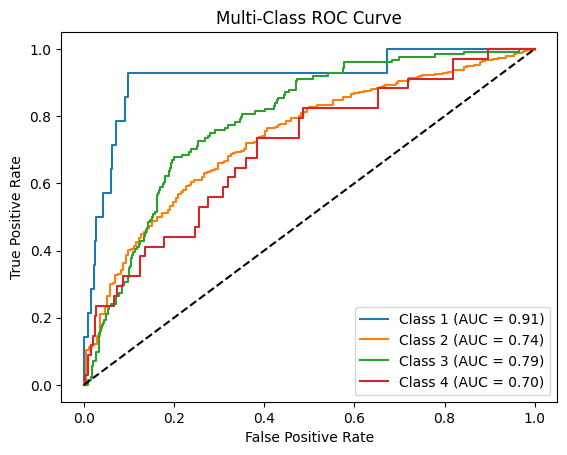

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Test Set Evaluation ===
Accuracy: 0.514
F1 Score: 0.6109255568702041
Classification Report:
               precision    recall  f1-score   support

           1       0.05      0.83      0.10         6
           2       0.94      0.51      0.66       857
           3       0.29      0.57      0.39       119
           4       0.03      0.39      0.06        18

    accuracy                           0.51      1000
   macro avg       0.33      0.58      0.30      1000
weighted avg       0.84      0.51      0.61      1000

Confusion Matrix:
 [[  5   1   0   0]
 [ 76 434 161 186]
 [ 15  24  68  12]
 [  3   5   3   7]]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


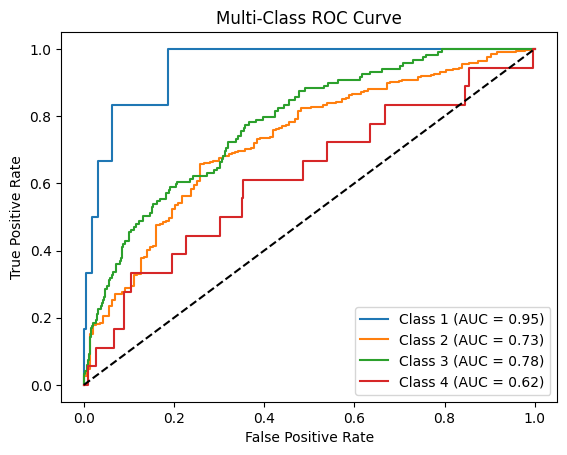

In [21]:
# Adjust labels to start from 0
label_offset = np.min(y_train)
y_train_adj = y_train - label_offset
y_val_adj = y_validate - label_offset
y_test_adj = y_test - label_offset  # for later

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_adj),
    y=y_train_adj
)
class_weights_dict = dict(enumerate(class_weights))

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y_train_adj)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using scaled features and adjusted labels
history = model.fit(
    X_train_scaled, y_train_adj,
    validation_data=(X_validate_scaled, y_val_adj),
    epochs=100,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

# Predict on validation set
y_val_probs = model.predict(X_validate_scaled)
y_val_pred_adj = y_val_probs.argmax(axis=1)
y_val_pred = y_val_pred_adj + label_offset  # revert to original labels

print("\n=== Validation Set Evaluation ===")
evaluate(y_val_pred, y_validate, X_validate_scaled, model)

# Predict on test set
y_test_probs = model.predict(X_test_scaled)
y_test_pred_adj = y_test_probs.argmax(axis=1)
y_test_pred = y_test_pred_adj + label_offset  # revert to original labels

print("\n=== Test Set Evaluation ===")
evaluate(y_test_pred, y_test, X_test_scaled, model)


# Backward Selection

Starting backward selection for 20 features...
Removed: Wind_Direction_ENE | Remaining: 63
Removed: Wind_Direction_NW | Remaining: 62
Removed: Wind_Direction_SSE | Remaining: 61
Removed: Wind_Direction_W | Remaining: 60
Removed: Wind_Direction_WNW | Remaining: 59
Removed: Weather_Day | Remaining: 58
Removed: Wind_Direction_WSW | Remaining: 57
Removed: Weather_Condition_Fog / Low Visibility | Remaining: 56
Removed: Wind_Direction_NNE | Remaining: 55
Removed: Wind_Direction_E | Remaining: 54
Removed: Wind_Direction_S | Remaining: 53
Removed: Wind_Direction_SSW | Remaining: 52
Removed: Wind_Direction_ESE | Remaining: 51
Removed: Wind_Direction_VAR | Remaining: 50
Removed: Wind_Direction_NE | Remaining: 49
Removed: Wind_Direction_NNW | Remaining: 48
Removed: Wind_Speed(mph) | Remaining: 47
Removed: Wind_Direction_SE | Remaining: 46
Removed: Weather_Day_of_Week | Remaining: 45
Removed: Wind_Direction_N | Remaining: 44
Removed: Wind_Direction_SW | Remaining: 43
Removed: Railway | Remaining: 

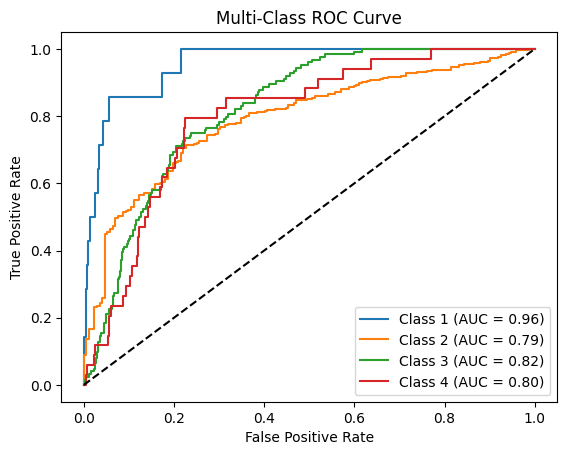

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Test Set Evaluation ===
Accuracy: 0.5
F1 Score: 0.5975514903535655
Classification Report:
               precision    recall  f1-score   support

           1       0.07      1.00      0.12         6
           2       0.97      0.47      0.64       857
           3       0.32      0.63      0.42       119
           4       0.05      0.72      0.10        18

    accuracy                           0.50      1000
   macro avg       0.35      0.71      0.32      1000
weighted avg       0.87      0.50      0.60      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 69 406 160 222]
 [ 16  12  75  16]
 [  1   2   2  13]]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


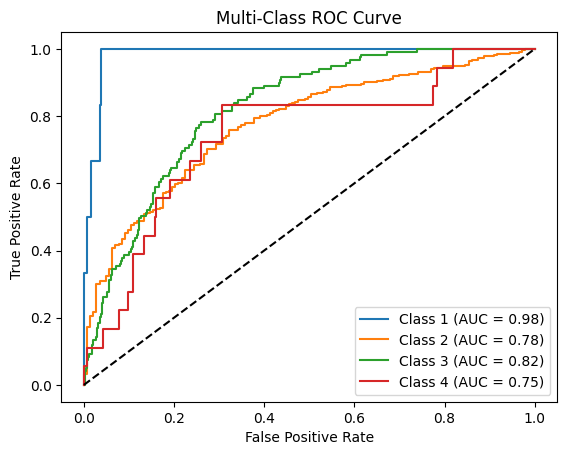

In [22]:
# ==== PARAMETER TO ADJUST ====
target_features = 20
# =============================

# Start with all features
selected_features = X_train.columns.tolist()
print(f"Starting backward selection for {target_features} features...")

# Use scaled feature DataFrames (already done earlier)
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_validate_df = pd.DataFrame(X_validate_scaled, columns=X_validate.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# === Backward Feature Selection Loop ===
while len(selected_features) > target_features:
    temp_model = Sequential([
        Dense(64, activation='relu', input_shape=(len(selected_features),)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(np.unique(y_train_adj)), activation='softmax')
    ])

    temp_model.compile(
        optimizer=Adam(0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    temp_model.fit(
        X_train_df[selected_features], y_train_adj,
        validation_data=(X_validate_df[selected_features], y_val_adj),
        epochs=50,
        batch_size=64,
        class_weight=class_weights_dict,
        callbacks=[EarlyStopping(patience=3)],
        verbose=0
    )

    # Drop least important feature
    weights = temp_model.layers[0].get_weights()[0]
    importance = pd.Series(np.abs(weights).mean(axis=1), index=selected_features)
    least_important = importance.idxmin()
    selected_features.remove(least_important)
    print(f"Removed: {least_important} | Remaining: {len(selected_features)}")

# === Final Model Training on Selected Features ===
X_train_selected = X_train_df[selected_features]
X_validate_selected = X_validate_df[selected_features]
X_test_selected = X_test_df[selected_features]

model = Sequential([
    Dense(128, activation='relu', input_shape=(target_features,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_adj)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_selected, y_train_adj,
    validation_data=(X_validate_selected, y_val_adj),
    epochs=100,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# === Evaluation on Validation Set ===
y_val_probs = model.predict(X_validate_selected)
y_val_pred = y_val_probs.argmax(axis=1) + label_offset
print("\n=== Validation Set Evaluation ===")
evaluate(y_val_pred, y_validate, X_validate_selected, model)

# === Evaluation on Test Set ===
y_test_probs = model.predict(X_test_selected)
y_test_pred = y_test_probs.argmax(axis=1) + label_offset
print("\n=== Test Set Evaluation ===")
evaluate(y_test_pred, y_test, X_test_selected, model)


# Parameter Tuning

In [23]:
def create_model(
    input_dim=20,
    units=128,
    learning_rate=0.001,
    dropout_rate=0.3,
    l2_reg=0.0001,
    num_layers=2,
    activation='relu',
    optimizer='adam'
):
    model = Sequential()
    model.add(Dense(units, activation=activation,
                    kernel_regularizer=regularizers.l2(l2_reg),
                    input_shape=(input_dim,)))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Dense(int(units * 0.8), activation=activation,
                        kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dropout(dropout_rate * 0.8))
    model.add(Dense(len(np.unique(y_train_adj)), activation='softmax'))
    opt = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

X_combined_selected = np.vstack([X_train_selected, X_validate_selected])
y_combined = np.concatenate([y_train_adj, y_val_adj])
val_fold = [-1] * len(X_train_selected) + [0] * len(X_validate_selected)

param_dist = {
    'model__units': [64, 128],
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.2, 0.3],
    'model__l2_reg': [0.001, 0.01],
    'model__num_layers': [2, 3],
    'model__activation': ['relu', 'elu'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [60]
}

model = KerasClassifier(
    build_fn=create_model,
    input_dim=X_train_selected.shape[1],  # dynamically based on selected features
    verbose=0
)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

searcher = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=2,
    n_iter=64
)

searcher.fit(
    X_combined_selected, y_combined,
    groups=val_fold,
    callbacks=[early_stop],
    validation_split=0.2
)

print("\n=== Best Hyperparameters ===")
print(searcher.best_params_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END batch_size=64, epochs=60, model__activation=elu, model__dropout_rate=0.2, model__l2_reg=0.001, model__learning_rate=0.001, model__num_layers=2, model__optimizer=adam, model__units=64; total time=  23.3s
[CV] END batch_size=64, epochs=60, model__activation=elu, model__dropout_rate=0.2, model__l2_reg=0.001, model__learning_rate=0.001, model__num_layers=2, model__optimizer=adam, model__units=64; total time=  23.3s
[CV] END batch_size=64, epochs=60, model__activation=elu, model__dropout_rate=0.2, model__l2_reg=0.001, model__learning_rate=0.001, model__num_layers=2, model__optimizer=adam, model__units=64; total time=  21.9s
[CV] END batch_size=32, epochs=60, model__activation=relu, model__dropout_rate=0.2, model__l2_reg=0.01, model__learning_rate=0.01, model__num_layers=2, model__optimizer=adam, model__units=128; total time=  39.5s
[CV] END batch_size=32, epochs=60, model__activation=relu, model__dropout_rate=0.2, model_

In [24]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()


=== Validation Set Evaluation ===
Accuracy: 0.616
F1 Score: 0.679582058008969
Classification Report:
               precision    recall  f1-score   support

           1       0.14      0.86      0.24        14
           2       0.96      0.60      0.74       828
           3       0.34      0.72      0.46       124
           4       0.12      0.44      0.19        34

    accuracy                           0.62      1000
   macro avg       0.39      0.65      0.41      1000
weighted avg       0.84      0.62      0.68      1000

Confusion Matrix:
 [[ 12   1   0   1]
 [ 55 500 167 106]
 [ 19  12  89   4]
 [  2  10   7  15]]


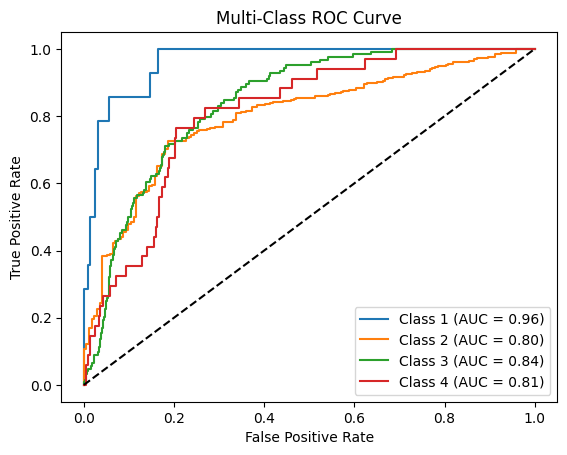


=== Test Set Evaluation ===
Accuracy: 0.613
F1 Score: 0.6888283046355452
Classification Report:
               precision    recall  f1-score   support

           1       0.08      1.00      0.16         6
           2       0.95      0.61      0.74       857
           3       0.31      0.65      0.42       119
           4       0.05      0.33      0.08        18

    accuracy                           0.61      1000
   macro avg       0.35      0.65      0.35      1000
weighted avg       0.85      0.61      0.69      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 53 524 172 108]
 [ 11  21  77  10]
 [  1   8   3   6]]


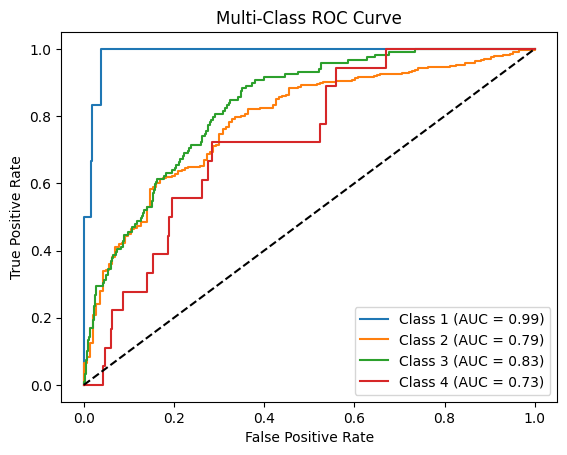

In [28]:
# Access best model correctly
best_model = searcher.best_estimator_

# Predict on validation set
y_val_probs = best_model.predict_proba(X_validate_selected)
y_val_pred = y_val_probs.argmax(axis=1) + label_offset
print("\n=== Validation Set Evaluation ===")
evaluate(y_val_pred, y_validate, X_validate_selected, best_model)

# Predict on test set
y_test_probs = best_model.predict_proba(X_test_selected)
y_test_pred = y_test_probs.argmax(axis=1) + label_offset
print("\n=== Test Set Evaluation ===")
evaluate(y_test_pred, y_test, X_test_selected, best_model)
